In [1]:
# this is needed to import lumiacc 
import sys
sys.path.append('/afs/cern.ch/work/a/adlintul/public/scouting/hbb/analysis/Run3ScoutingHbb')
from processors import lumiacc

import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot
import math
from coffea import util

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

In [90]:
output = util.load(f"../outfiles/Run3Summer22EE/ddt/msd_weight/dask_QCD.coffea")[0]

In [91]:
with open("../data/xsec/xsec.json", "r") as json_file:
    xs = json.load(json_file)

In [92]:
from coffea.lumi_tools import LumiData, LumiList

path_lumi_csv = "../data/lumi/Cert_Collisions2022_355100_362760_Golden.csv"
lumidata = LumiData(path_lumi_csv)

out_dir = "../outfiles/Run3Summer22EE/cutflow/pt_jet_arbitration"
data_file = "dask_ScoutingPFRun3_Run2022EF.coffea"
data = util.load(f"{out_dir}/{data_file}")

total = 0

for dataset, lumilist in data[0]['lumilist'].items():
    lumi_list = data[0]['lumilist'][dataset]
    lumi_list.unique()
    lumi = lumidata.get_lumi(lumi_list)
    total += lumi
    
    print(f"{dataset}: {lumi:.2f} /pb")

print()
print(f"Total: {total:.2f} /pb")
print(f"Total: {total/1000:.2f} /fb")

ScoutingPFRun3_Run2022E_359037-359764_231116_133654_0000: 103.60 /pb
ScoutingPFRun3_Run2022F_360941-361417_231116_135412_0002: 17.79 /pb
ScoutingPFRun3_Run2022F_361417-362167_231116_135213_0004: 5.14 /pb
ScoutingPFRun3_Run2022F_361417-362167_231116_135213_0003: 6.85 /pb
ScoutingPFRun3_Run2022F_361417-362167_231116_135213_0002: 5.79 /pb
ScoutingPFRun3_Run2022F_361417-362167_231116_135213_0000: 0.87 /pb
ScoutingPFRun3_Run2022F_360941-361417_231116_135412_0003: 17.86 /pb
ScoutingPFRun3_Run2022F_360335-360941_231116_135552_0000: 10.94 /pb
ScoutingPFRun3_Run2022F_360941-361417_231116_135412_0001: 9.46 /pb
ScoutingPFRun3_Run2022F_360941-361417_231116_135412_0000: 2.31 /pb
ScoutingPFRun3_Run2022F_360335-360941_231116_135552_0001: 28.84 /pb
ScoutingPFRun3_Run2022E_359776-359764_231115_090938_0001: 47.09 /pb
ScoutingPFRun3_Run2022E_359776-359764_231115_090938_0002: 25.12 /pb
ScoutingPFRun3_Run2022E_359037-359764_231116_133654_0001: 156.44 /pb
ScoutingPFRun3_Run2022E_359776-359764_231115_090938_

In [93]:
output["h"] = output["h"].project('dataset', 'rho', 'pt', 'n2b1')

scale_lumi = {k: xs[k] * total / w for k, w in output['sumw'].items()}

for i, name in enumerate(output["h"].axes["dataset"]):
    output["h"].view(flow=True)[i] *= scale_lumi[name]

# Table of contents

* [Create DDT map](#create)
* [Using the DDT map](#use)
* [Variable plots](#plot)

# Create the DDT map <a class="anchor" id="create"></a>

In [6]:
# 3D hist
# bin: (rho, pt, n2b1)
# value: number of jets
ddthist = output['h'][{'dataset' : sum}]

val_QCD = ddthist.values()
var_QCD = ddthist.variances()

# 3D array
# bin: (rho, pt, n2b1)
# value: cumulative sum of number of jets
qcd_maxval_temp = np.cumsum(val_QCD, axis=2)

# 2D array
# bin: (rho, pt)
# value: total cumulative sum of number of jets
qcd_maxval = qcd_maxval_temp[:, :, -1]

# 3D array
# bin: (rho, pt, n2b1)
# value: number of jets divided by total cumulative sum, i.e. an efficiency
norma = qcd_maxval_temp / np.maximum(1e-10, qcd_maxval[:, :, np.newaxis])

from copy import copy, deepcopy
hist_y_QCD = deepcopy(ddthist)
# template = hist_y_QCD[{"n2b1" : sum}]
template = Hist(
    hist.axis.Regular(100, -8, -0.5, name="rho", label=r"$\rho=ln(m^2_{reg}/p_T^2)$"),
    hist.axis.Regular(100, 250, 1350, name="pt", label=r"$p_T$ (GeV)"),
)

# 3D hist
# bin: (rho, pt, n2b1)
# value: number of jets divided by total cumulative sum
# hist_y_QCD[:, :, :] = norma
hist_y_QCD[:, :, :] = np.append(norma[:, :, :, np.newaxis], var_QCD[:, :, :, np.newaxis], axis=3)

In [7]:
# find the index of 26% efficiency in norma
eff=0.26
res = np.apply_along_axis(lambda norma: norma.searchsorted(eff), axis = 2, arr = norma)
res[res>1000]=0

# find the n2b1 value that corresponds to the index
def bineval(a):
    return hist_y_QCD.project("n2b1").axes[0].edges[a]

binfunc = np.vectorize(bineval)
qmap = binfunc(res)
qmap[qmap == -math.inf] = 0

template[:, :] = qmap
# var_temp = template.variances()
# template[:, :] = np.append(qmap[:, :, np.newaxis], var_temp[:, :, np.newaxis], axis=2)

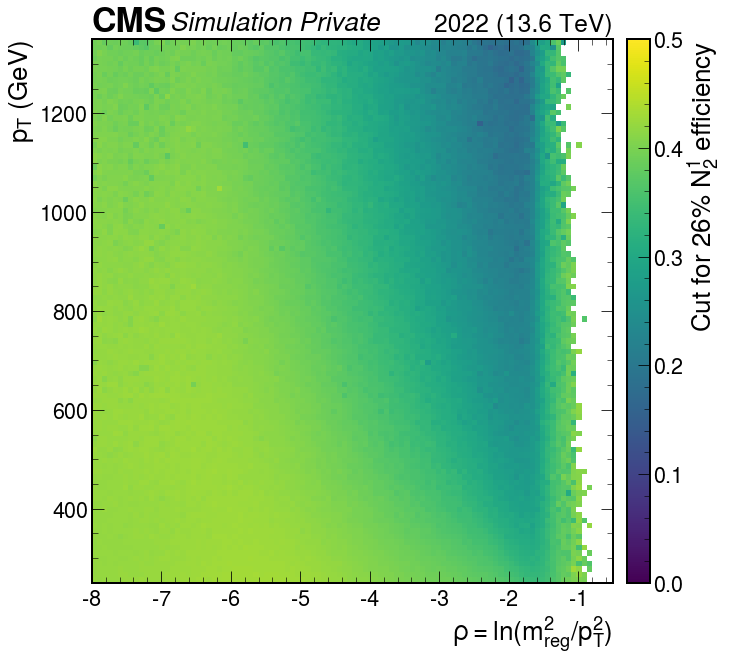

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.style.use(mplhep.style.CMS)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")
_, c, _ = mplhep.hist2dplot(template.project("rho", "pt"), cmin=0, cmax=0.5, cbarsize="4%")
ylabel = c.set_label(r"Cut for 26% $N_2^1$ efficiency")

/tmp/adlintul/ipykernel_17271/2685721240.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_ddtmap = sc.filters.gaussian_filter(template.project("rho", "pt").values(), 1)


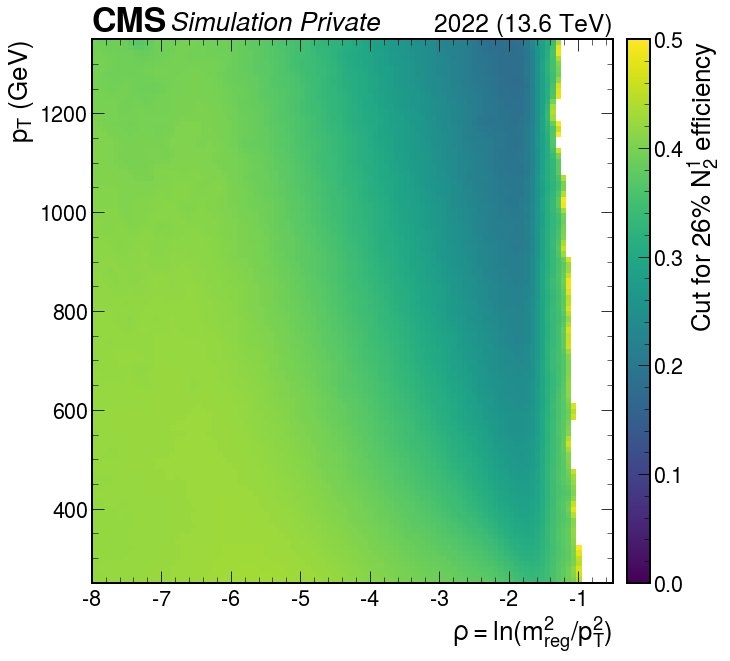

In [17]:
import scipy.ndimage as sc

smooth_ddtmap = sc.filters.gaussian_filter(template.project("rho", "pt").values(), 1)

template_smooth = deepcopy(template)
template_smooth[:, :] = smooth_ddtmap

fig, ax = plt.subplots(figsize=(10, 10))
plt.style.use(mplhep.style.CMS)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")
_, c, _ = mplhep.hist2dplot(template_smooth, cmin=0, cmax=0.5, cbarsize="4%")
ylabel = c.set_label(r"Cut for 26% $N_2^1$ efficiency")

## Using the DDT map <a class="anchor" id="use"></a>

In [13]:
from coffea.lookup_tools.dense_lookup import dense_lookup

lookup = dense_lookup(template_smooth.view(), (template_smooth.axes[0].edges, template_smooth.axes[1].edges))

In [14]:
# Example: FatJet.rho = -3.4 and FatJet.pt = 500

lookup(-3.4, 730)

0.31795627704982143

In [15]:
import pickle

picklename = f"../data/n2b1/ddt_msd_map.pkl"

outfile = open(picklename, 'wb')
pickle.dump(lookup, outfile, protocol=-1)
outfile.close()

## Variable plots <a class="anchor" id="plot"></a>

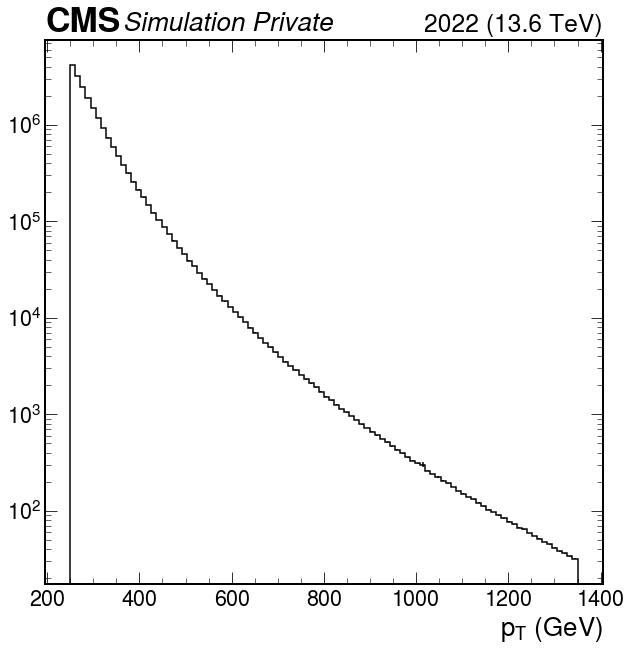

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))


mplhep.histplot(
    output['h'][{
        'n2b1' : slice(0, len, sum),
        'rho' : slice(0, len, sum),
        'dataset' : slice(0, len, sum),
    }],
    ax=ax,
    flow='none',
    color='black',
)

ax.set_yscale('log')

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

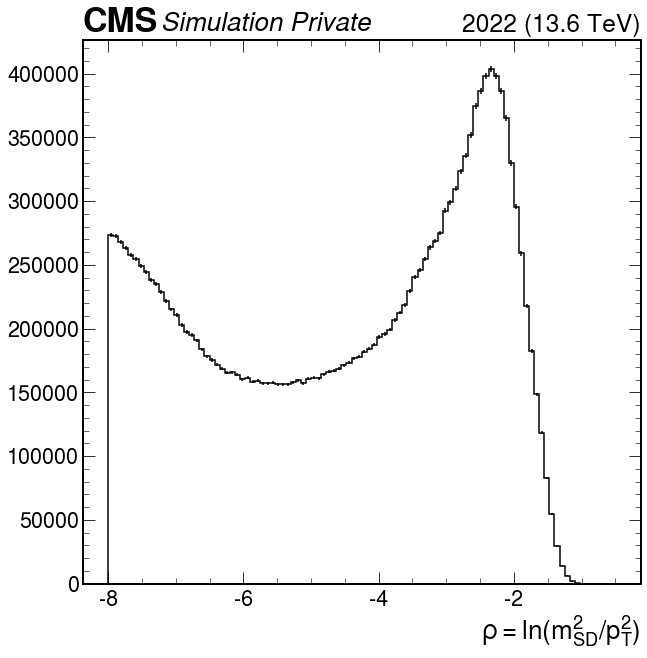

In [99]:
fig, ax = plt.subplots(figsize=(10, 10))


mplhep.histplot(
    output['h'][{
        'n2b1' : slice(0, len, sum),
        'pt' : slice(0, len, sum),
        'dataset' : slice(0, len, sum),
    }],
    ax=ax,
    flow='none',
    color='black',
)

# ax.set_yscale('log')

ax.set_xlabel(r"$\rho=ln(m^2_{SD}/p_T^2)$")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

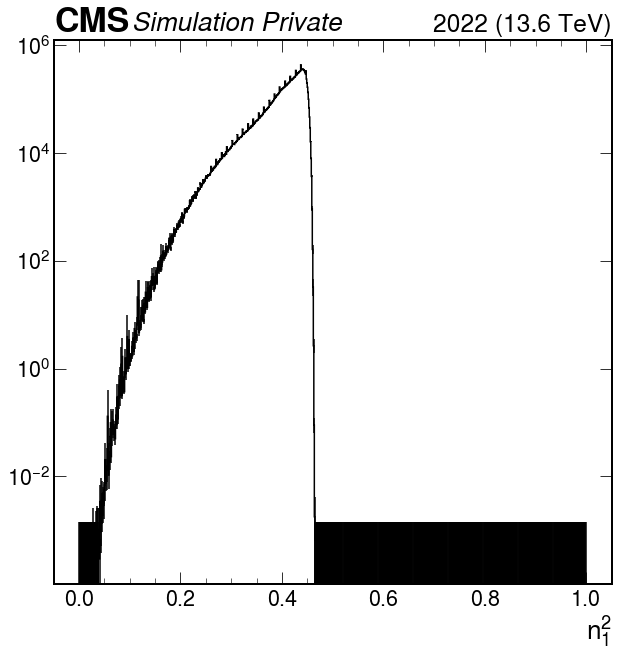

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))


mplhep.histplot(
    output['h'][{
        'pt' : slice(0, len, sum),
        'rho' : slice(0, len, sum),
        'dataset' : slice(0, len, sum),
    }],
    ax=ax,
    flow='none',
    color='black',
)

ax.set_yscale('log')

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

/tmp/adlintul/ipykernel_17271/3534445708.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)


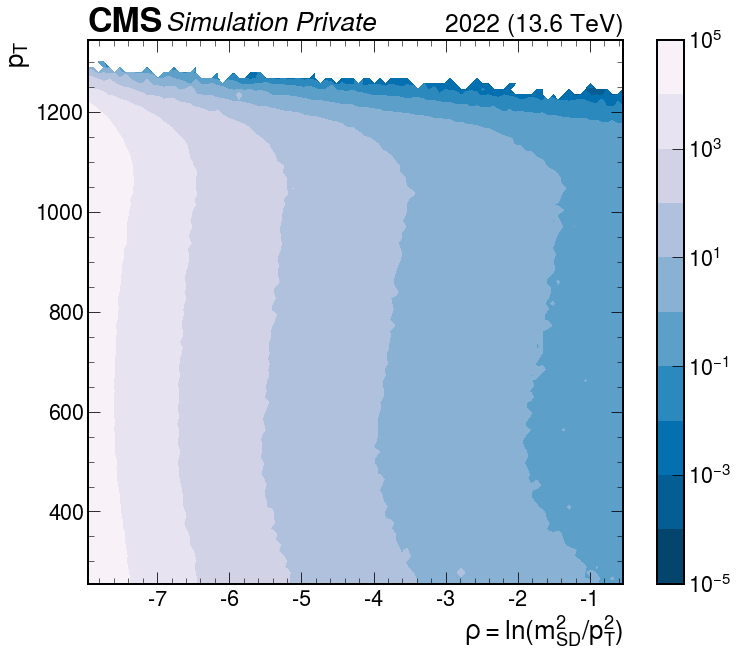

In [102]:
from matplotlib import cm, ticker

h = output['h'][{
    'n2b1' : slice(0, len, sum),
    'dataset' : slice(0, len, sum),
}]

X = h.axes[0].centers
Y = h.axes[1].centers
z = h.values()

fig, ax = plt.subplots(figsize=(12, 10))
cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

ax.set_ylabel(r"$p_T$")
ax.set_xlabel(r"$\rho=ln(m^2_{SD}/p_T^2)$")
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

fig.colorbar(cs)